In [1]:
import h5py
import numpy as np
import torch
from transformers import AutoModelForCausalLM, AutoTokenizer
import joblib
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import pandas as pd
import tqdm
import matplotlib.pyplot as plt

/home/ljf1/dis/lora/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
def get_dataset(system_id=0, points=100):

    with h5py.File("lotka_volterra_data.h5", "r") as f:
        trajectories = f["trajectories"][:]
        time_points = f["time"][:]
        prey = trajectories[system_id, :points, 0]
        predator = trajectories[system_id, :points, 1]
        times = time_points[:points]

    return prey, predator, times

In [3]:
def load_qwen():
    model_name = "Qwen/Qwen2.5-0.5B-Instruct"
    tokenizer = AutoTokenizer.from_pretrained(model_name, trust_remote_code=True)
    model = AutoModelForCausalLM.from_pretrained(model_name, trust_remote_code=True)

    # Freeze all parameters except LM head bias
    for param in model.parameters():
        param.requires_grad = False

    # Add trainable bias to logits
    assert model.lm_head.bias is None
    model.lm_head.bias = torch.nn.Parameter(
        torch.zeros(model.config.vocab_size, device=model.device)
    )
    model.lm_head.bias.requires_grad = True

    return model, tokenizer

In [38]:
def alpha_scaler(data, alpha, decimals=3):
    data = np.array(data)
    alpha_percentile = np.percentile(data, alpha)
    rescaled = data/alpha_percentile * 10
    scaled = rescaled / rescaled.max()
    return np.round(scaled, decimals = decimals)

def reverse_scaler(scaled, original, alpha, decimals=3):
    scaled = np.array(scaled)
    alpha_percentile = np.percentile(original, alpha)
    rescaled = scaled * alpha_percentile / 10
    original = rescaled * rescaled.max()
    return original

In [ ]:
def encoding(prey, predator):
    series = np.column_stack((prey, predator))
    encoded = ';'.join([','.join(map(str, row)) for row in series])
    return encoded

def decoding(data):
    time_steps = data.split(';')
    decoded = np.array([list(map(float, step.split(','))) 
                        for step in time_steps 
                        if step.strip() 
                        and len(step.split(',')) == 2 
                        and all(value.strip() for value in step.split(','))]
                        [:100])
    prey = decoded[:, 0]
    predator = decoded[:, 1]
    return prey, predator

In [6]:
model, tokenizer = load_qwen()

def process_data(system_id=0, points=100, alpha=40, decimals=3):
    prey, predator, times = get_dataset(system_id=system_id, points=points)
    new_prey = alpha_scaler(prey, alpha=alpha, decimals=decimals)
    new_predator = alpha_scaler(predator, alpha=alpha, decimals=decimals)
    encoded = encoding(new_prey, new_predator)
    tokenized_data = tokenizer(encoded, return_tensors="pt")
    return tokenized_data, encoded, np.column_stack((prey, predator, new_prey, new_predator)), times

Sliding Window Attention is enabled but not implemented for `sdpa`; unexpected results may be encountered.


In [7]:
example_tokenized_data, example_preprocessed_data = process_data(system_id=700, points=3)[:2]
print("Preprocessed data:", example_preprocessed_data)
print("Tokenized results:", example_tokenized_data["input_ids"].tolist()[0])

Preprocessed data: 2.288,0.951;1.121,1.084;0.515,1.012
Tokenized results: [17, 13, 17, 23, 23, 11, 15, 13, 24, 20, 16, 26, 16, 13, 16, 17, 16, 11, 16, 13, 15, 23, 19, 26, 15, 13, 20, 16, 20, 11, 16, 13, 15, 16, 17]


In [43]:
def generate_data(system_id=0, output_points=100, alpha=40, decimals=3):

    full_tokenized_data, _, full_combined_data, full_times = process_data(system_id=system_id, points=100, alpha=alpha, decimals=decimals)
    
    max_token_length = full_tokenized_data["input_ids"].shape[1] + 1 #1180
    
    actual_prey, actual_predator = full_combined_data[:,2], full_combined_data[:,3]

    tokenized_data = process_data(system_id=system_id, points=output_points)[0]
    
    with torch.no_grad():
        output = model.generate(tokenized_data["input_ids"], attention_mask = tokenized_data["attention_mask"], max_new_tokens = max_token_length)
    
    prediction = tokenizer.decode(output[0])
    pred_prey, pred_predator = decoding(prediction)
    
    return pred_prey, pred_predator, actual_prey, actual_predator, full_times

In [50]:
random_system_id = np.random.uniform(0, 1000, 1).astype(int)[0]
full_tokenized_data, full_preprocessed_data, full_combined_data, full_times = process_data(system_id=random_system_id, points=100)
max_token_length = full_tokenized_data["input_ids"].shape[1] + 1 #1180
actual_prey, actual_predator = full_combined_data[:,2], full_combined_data[:,3]
tokenized_data, preprocessed_data, combined_data, times = process_data(system_id=random_system_id, points=80)
with torch.no_grad():
    output = model.generate(tokenized_data["input_ids"], attention_mask = tokenized_data["attention_mask"], max_length = max_token_length)
prediction = tokenizer.decode(output[0])
pred_prey, pred_predator = decoding(prediction)

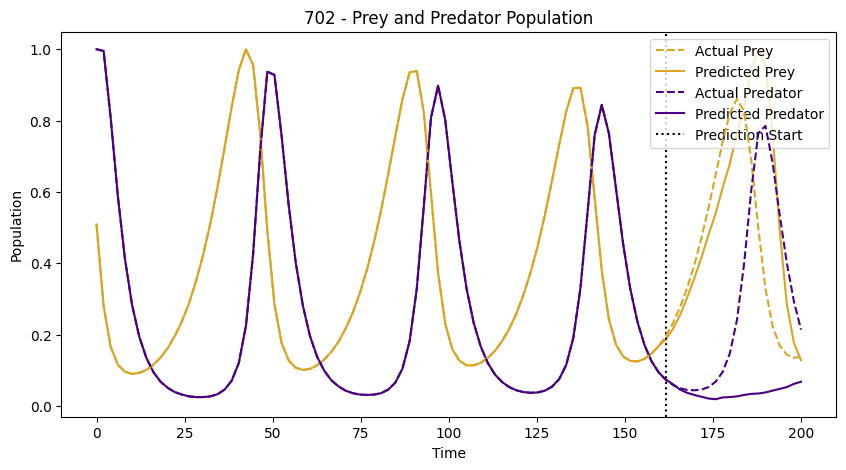

In [51]:
fig, ax = plt.subplots(figsize=(10, 5))
ax.set_title(f"{random_system_id} - Prey and Predator Population")
ax.plot(full_times, actual_prey, label="Actual Prey", linestyle="--", zorder=100, color="goldenrod")
ax.plot(full_times, pred_prey, label="Predicted Prey", color="goldenrod")
ax.plot(full_times, actual_predator, label="Actual Predator", linestyle="--", zorder=100, color="indigo")
ax.plot(full_times, pred_predator, label="Predicted Predator", color="indigo")
ax.set_xlabel("Time")
ax.set_ylabel("Population")
ax.axvline(full_times[80], color="black", linestyle="dotted", label="Prediction Start")
ax.legend()
plt.show()

In [ ]:
print("MEAN PREY SQUARED ERROR:", mean_squared_error(pred_prey, actual_prey))
print("MEAN PREY ABSOLUTE ERROR:", mean_absolute_error(pred_prey, actual_prey))
print("R2 PREY SCORE:", r2_score(pred_prey, actual_prey))
print("MEAN PREDATOR SQUARED ERROR:", mean_squared_error(pred_predator, actual_predator))
print("MEAN PREDATOR ABSOLUTE ERROR:", mean_absolute_error(pred_predator, actual_predator))
print("R2 PREDATOR SCORE:", r2_score(pred_predator, actual_predator))

MEAN PREY SQUARED ERROR: 1.603235858126217
MEAN PREY ABSOLUTE ERROR: 0.9717399981451034
R2 PREY SCORE: -0.3990795007916992
MEAN PREDATOR SQUARED ERROR: 10.83784771919629
MEAN PREDATOR ABSOLUTE ERROR: 2.1435399981427192
R2 PREDATOR SCORE: -0.34271854398405055


In [ ]:
# def calculate_flops(batch_size, sequence_length, embedding_dim, num_heads, num_layers):
#     token_embedding = batch_size * sequence_length * (embedding_dim * 2 - 1)
    
#     attention = (batch_size * sequence_length * (embedding_dim * 2 - 1)*3 + 
#                  batch_size * num_heads * sequence_length**2 * 2 )